In [31]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Retrieving data with StatAPI

### Imports

In [32]:
import datetime as dt
from functools import partial

import json
import pandas as pd
import geopandas as gpd
import numpy as np
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as cols

import shapely

In [33]:
from util import stat_to_df
from sentinelhub import (
    SentinelHubRequest, DataCollection, SHConfig,
    SentinelHubStatisticalDownloadClient, SentinelHubStatistical,
    CRS, BBox, Geometry, bbox_to_dimensions, 
    parse_time_interval, MimeType, WcsRequest
)

In [34]:
# helper function
def to_download_requests(gdf, data_folder=None):
    """ function to create StatAPI request per each geometry in geopandas geoDataFrame 
    
    :param: data_folder: specify a folder to cache the responses from SH service - particularly useful when testing
    """
    
    stat_requests = []
    for row in gdf.itertuples():
        req = SentinelHubStatistical(
            aggregation=aggregation, 
            calculations=calculations, 
            input_data=[input_data], 
            geometry=Geometry(row.geometry, crs=CRS(gdf.crs.to_epsg())),
            data_folder=data_folder
        )
        stat_requests.append(req)
    
    download_requests = [stat_request.download_list[0] for stat_request in stat_requests]
    
    if data_folder:
        for download_request in download_requests:
            download_request.save_response = True
    
    return download_requests

## Fetch statististat_to_df using sh-py + StatAPI

Evalscript to retrieve data:

In [35]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: [{
      bands: ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B10", "B11", "B12", "CLM", "CLP", "dataMask"],
      units: "DN"
    }],
    output: [
      {
        id: "bands",
        bands: ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B10", "B11", "B12"],
        sampleType: "UINT16"
      },
      {
        id: "masks",
        bands: ["CLM"],
        sampleType: "UINT16"
      },
      {
        id: "indices",
        bands: ["NDVI", "NDVI_RE1", "NBSI", "CLP"],
        sampleType: "UINT16"
      },
      {
        id: "dataMask",
        bands: 1
      }]
  }
}

function evaluatePixel(samples) {
    // Normalised Difference Vegetation Index and variation
    let NDVI = index(samples.B08, samples.B04);
    let NDVI_RE1 = index(samples.B08, samples.B05);

    // Bare Soil Index 
    let NBSI = index((samples.B11 + samples.B04), (samples.B08 + samples.B02));
    
    // cloud probability normalized to 0..1
    let CLP = samples.CLP/255.0;
        
    const f = 5000;
    return {
        bands: [samples.B01, samples.B02, samples.B03, samples.B04, samples.B05, samples.B06, 
                samples.B07, samples.B08, samples.B8A, samples.B09, samples.B10, samples.B11, samples.B12],
        masks: [samples.CLM],
        indices: [toUINT(NDVI, f), toUINT(NDVI_RE1, f), toUINT(NBSI, f), toUINT(CLP, f)],
        dataMask: [samples.dataMask]
    };
}

function toUINT(product, constant){
  // Clamp the output to [-1, 10] and convert it to a UNIT16
  // value that can be converted back to float later.
  if (product < -1) {
    product = -1;
  } else if (product > 10) {
    product = 10;
  }
  return Math.round(product * constant) + constant;
}

function feature_ratio(band_a, band_b, constant){
  // Compute Band Ratio of the form A/B + constant.
  return (band_a / band_b) + constant;
}

"""

In [36]:
kranj_wgs84 = [14.26, 46.26, 14.51, 46.11]
bbox = BBox(bbox=kranj_wgs84, crs=CRS.WGS84)

In [37]:
time_interval = ('2022-03-01', '2022-09-01')

In [38]:
wcs_true_color_request = WcsRequest(
    data_collection=DataCollection.SENTINEL2_L1C,
    data_folder="./cache/",
    layer='TRUE-COLOR-S2-L1C',
    bbox=bbox,
    time=time_interval,
    resx = "60m",
    resy = "60m",
    image_format= MimeType.TIFF
)
images = wcs_true_color_request.get_data(save_data=True)
len(images)

37

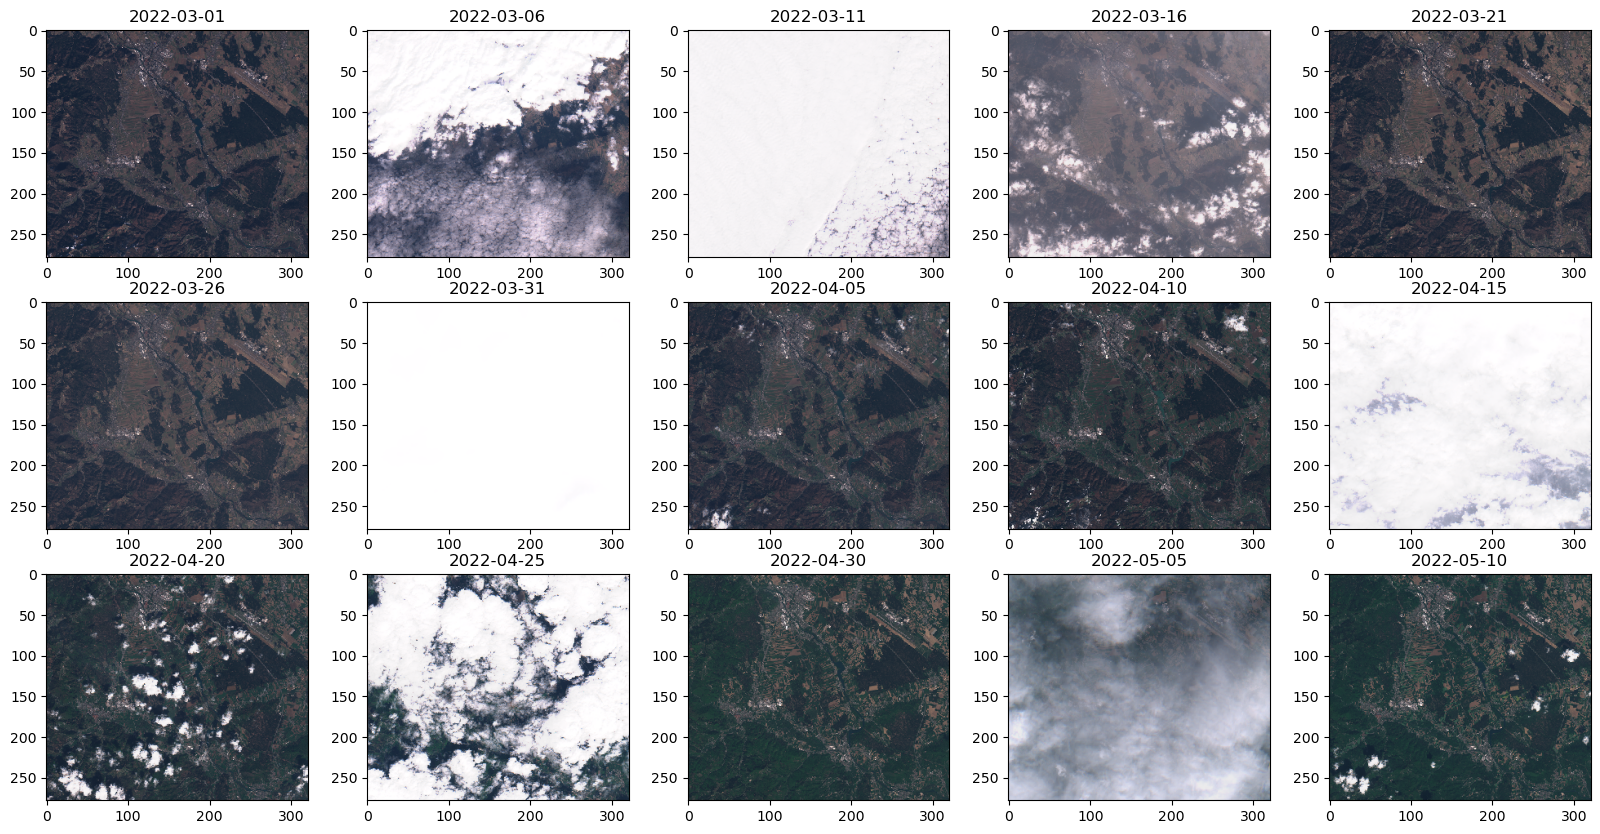

In [39]:
fig, axs = plt.subplots(3,5, figsize=(20,10))
for idx, (image, datum) in enumerate(zip(images[:15], wcs_true_color_request.get_dates()[:15])):
    axs.flat[idx].imshow(image)
    axs.flat[idx].set_title(datum.date().isoformat())

In [40]:
resolution=(10,10)

In [41]:
aggregation = SentinelHubStatistical.aggregation(
    evalscript=evalscript,
    time_interval=time_interval,
    aggregation_interval='P1D',
    size=bbox_to_dimensions(bbox, 100))

In [42]:
input_data = SentinelHubRequest.input_data(DataCollection.SENTINEL2_L1C, maxcc=1)

<div class="alert alert-block alert-info">
    We will request default statistics + [5,50,90]th percentiles for all outputs.

In [43]:
calculations = {
    "default": {
      "statistics": {
        "default": {
          "percentiles": {
            "k": [5, 50, 95]
          }
        }
      }
    }
}

In [44]:
stats = SentinelHubStatistical(
    aggregation=aggregation, 
    data_folder="./cache/",
    calculations=calculations, 
    input_data=[input_data],
    bbox=bbox
)

In [45]:
%%time
res = stats.get_data(save_data=True)[0]

CPU times: total: 0 ns
Wall time: 9.97 ms


<div class="alert alert-block alert-info">
Beware that with StatAPI the response can contain errors for particular intervals. (With FIS, whole response failed if single timestamp failed.) This is how erroneous data looks like:
</div>

```javascript
{'interval': {'from': '2020-12-21T00:00:00Z', 'to': '2020-12-22T00:00:00Z'}, 'error': {'type': 'EXECUTION_ERROR'}}
{'interval': {'from': '2020-12-26T00:00:00Z', 'to': '2020-12-27T00:00:00Z'}, 'error': {'type': 'EXECUTION_ERROR'}}
{'interval': {'from': '2020-12-31T00:00:00Z', 'to': '2021-01-01T00:00:00Z'}, 'error': {'type': 'EXECUTION_ERROR'}}
```

In [46]:
res['data'][0]['interval']

{'from': '2022-03-01T00:00:00Z', 'to': '2022-03-02T00:00:00Z'}

In [47]:
res['data'][2]['outputs']['indices']['bands']['NDVI']

{'stats': {'max': 6877.0,
  'mean': 5250.028084973365,
  'min': 4861.0,
  'noDataCount': 0,
  'percentiles': {'5.0': 5154.0, '50.0': 5212.0, '95.0': 5500.0},
  'sampleCount': 32010,
  'stDev': 125.82355925947826}}

<div class="alert alert-block alert-info">
Converting the response to `pandas` dataframe, we get:
</div>



In [48]:
res_df = stat_to_df(res)

In [49]:
res_df.head()

,interval_from,interval_to,bands_B01_max,bands_B01_mean,bands_B01_min,bands_B01_noDataCount,bands_B01_percentiles_5.0,bands_B01_percentiles_50.0,bands_B01_percentiles_95.0,bands_B01_sampleCount,...,indices_NDVI_RE1_stDev,masks_CLM_max,masks_CLM_mean,masks_CLM_min,masks_CLM_noDataCount,masks_CLM_percentiles_5.0,masks_CLM_percentiles_50.0,masks_CLM_percentiles_95.0,masks_CLM_sampleCount,masks_CLM_stDev
0,2022-03-01,2022-03-02,3532.0,1330.517463,1118.0,0,1185.0,1315.0,1520.0,32010,...,614.936836,0.0,0.000000,0.0,0,0.0,0.0,0.0,32010,0.000000
1,2022-03-06,2022-03-07,11913.0,4279.172102,1450.0,0,1649.0,2944.0,9059.0,32010,...,371.570199,1.0,0.818494,0.0,0,0.0,1.0,1.0,32010,0.385437
2,2022-03-11,2022-03-12,7135.0,5765.557170,1824.0,0,3710.0,6088.0,6596.0,32010,...,101.429289,1.0,1.000000,1.0,0,1.0,1.0,1.0,32010,0.000000
3,2022-03-16,2022-03-17,5933.0,2220.816401,1764.0,0,1866.0,2068.0,3264.0,32010,...,197.566426,1.0,0.978132,0.0,0,1.0,1.0,1.0,32010,0.146253
4,2022-03-21,2022-03-22,3337.0,1322.177507,1074.0,0,1156.0,1300.0,1543.0,32010,...,556.777428,0.0,0.000000,0.0,0,0.0,0.0,0.0,32010,0.000000


### Conversion function to back to "float"

<div class="alert alert-block alert-info">
As our evalscript is requesting outputs as unsigned integers, we want to transform statistics back:
</div>

In [50]:
float_res_df = res_df.copy()

for index in ["NDVI", "NDVI_RE1", "NBSI", "CLP"]:
    for stat in ['mean', 'min', 'max', 'stDev', 'percentiles_5.0', 'percentiles_50.0', 'percentiles_95.0']:
        col = f'indices_{index}_{stat}'
        if stat == 'stDev':
            float_res_df[col] = float_res_df[col] / 5000.
        else:
            float_res_df[col] = (float_res_df[col] - 5000.) / 5000.

<div class="alert alert-block alert-info">
Note: statistics for S-2 bands are still in DNs, so should be divided by 1.e4 to get to statistics for reflectances.
</div>

In [51]:
float_res_df.head()

,interval_from,interval_to,bands_B01_max,bands_B01_mean,bands_B01_min,bands_B01_noDataCount,bands_B01_percentiles_5.0,bands_B01_percentiles_50.0,bands_B01_percentiles_95.0,bands_B01_sampleCount,...,indices_NDVI_RE1_stDev,masks_CLM_max,masks_CLM_mean,masks_CLM_min,masks_CLM_noDataCount,masks_CLM_percentiles_5.0,masks_CLM_percentiles_50.0,masks_CLM_percentiles_95.0,masks_CLM_sampleCount,masks_CLM_stDev
0,2022-03-01,2022-03-02,3532.0,1330.517463,1118.0,0,1185.0,1315.0,1520.0,32010,...,0.122987,0.0,0.000000,0.0,0,0.0,0.0,0.0,32010,0.000000
1,2022-03-06,2022-03-07,11913.0,4279.172102,1450.0,0,1649.0,2944.0,9059.0,32010,...,0.074314,1.0,0.818494,0.0,0,0.0,1.0,1.0,32010,0.385437
2,2022-03-11,2022-03-12,7135.0,5765.557170,1824.0,0,3710.0,6088.0,6596.0,32010,...,0.020286,1.0,1.000000,1.0,0,1.0,1.0,1.0,32010,0.000000
3,2022-03-16,2022-03-17,5933.0,2220.816401,1764.0,0,1866.0,2068.0,3264.0,32010,...,0.039513,1.0,0.978132,0.0,0,1.0,1.0,1.0,32010,0.146253
4,2022-03-21,2022-03-22,3337.0,1322.177507,1074.0,0,1156.0,1300.0,1543.0,32010,...,0.111355,0.0,0.000000,0.0,0,0.0,0.0,0.0,32010,0.000000


## Run on all geometries from geodataframe

<div class="alert alert-block alert-info">
    To showcase how to run this on a large(r) number of geometries, using `sh-py` to do the multithreading etc., we've constructed a geoDataFrame with four polygons somewhere in Slovenia, over four different land covers: water, forest, agricultural fields and urban fabric.

In [52]:
gdf = gpd.read_file('../data/statapi_kranj.geojson')

In [53]:
gdf.head()

,type,geometry
0,Meadow,"POLYGON ((14.32473 46.23212, 14.32513 46.23046..."
1,Agricultural,"POLYGON ((14.34912 46.25535, 14.34940 46.25345..."
2,Water,"POLYGON ((14.40093 46.20024, 14.40154 46.19887..."
3,Forest,"POLYGON ((14.33880 46.26570, 14.33882 46.26445..."
4,Urban,"POLYGON ((14.35496 46.24100, 14.35427 46.23840..."


calculations = {
    "default": {
      "statistics": {
        "default": {
          "percentiles": {
            "k": [5, 50, 95]
          }
        }
      }
    }
}<div class="alert alert-block alert-info">
    We will convert the geometries to UTM_33N coordinate reference system, as the Sentinel-2 tiles in Slovenia are originally in this UTM, but we could do the requests in WGS as well.

In [54]:
gdf_utm = gdf.to_crs(epsg=32633)

In [55]:
download_requests = to_download_requests(gdf_utm)

In [56]:
client = SentinelHubStatisticalDownloadClient()
stat_data = client.download(download_requests)

In [57]:
len(stat_data)

5

<div class="alert alert-block alert-info">
    We got back 5 responses, ordered in the same way as the rows in the `gdf_utm` are, so we can construct a full dataframe (adding land cover type) to the responses, and transforming the statistics for indices:


In [58]:
indices = list(stat_data[0]['data'][0]['outputs']['indices']['bands'].keys())
statistics = ['min', 'max', 'mean', 'stDev']

dfs = []
for idx, stat in enumerate(stat_data):
    df = stat_to_df(stat)
    
    for index in indices:
        for stat in statistics:
            col = f'indices_{index}_{stat}'
            if stat == 'stDev':
                df[col] = df[col] / 5000.
            else:
                df[col] = (df[col] - 5000.) / 5000.
    
    df['type'] = gdf_utm.iloc[idx].type
    dfs.append(df)

data = pd.concat(dfs)

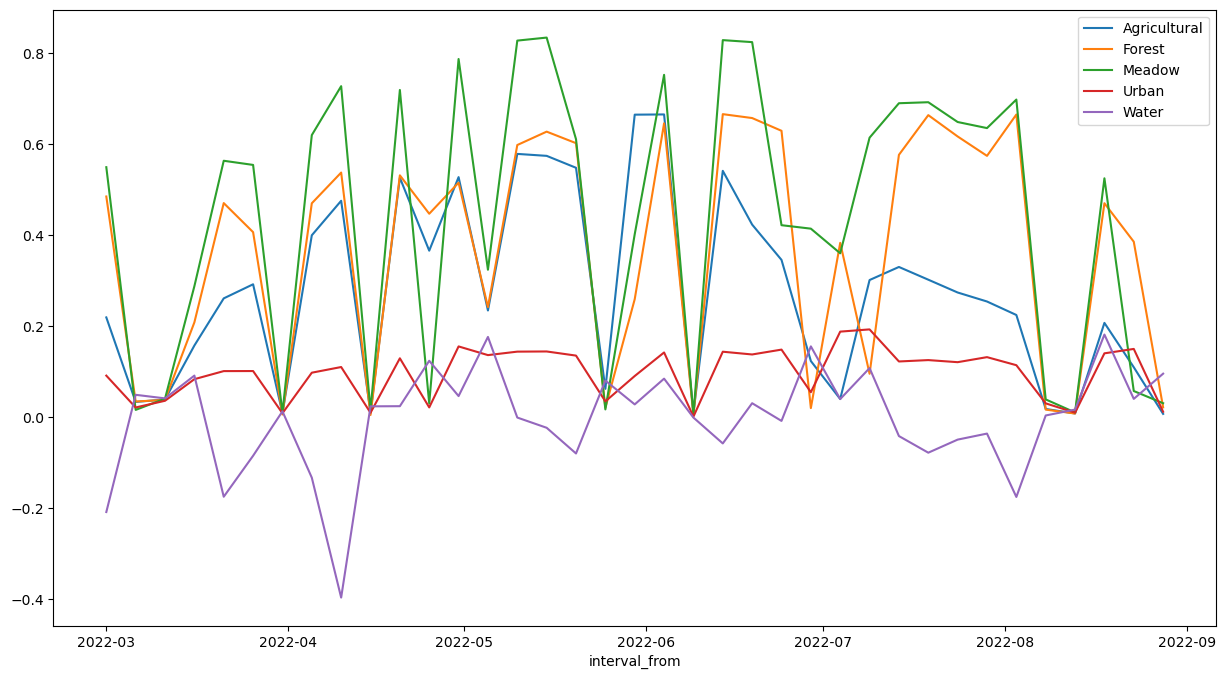

In [59]:
fig, ax = plt.subplots(figsize=(15,8))
data.set_index('interval_from').groupby('type')['indices_NDVI_mean'].plot(ax=ax, legend=True);

It is clear that the four geometries are significantly different from each other, but the time series is very jagged. Let's use the information about the clouds:

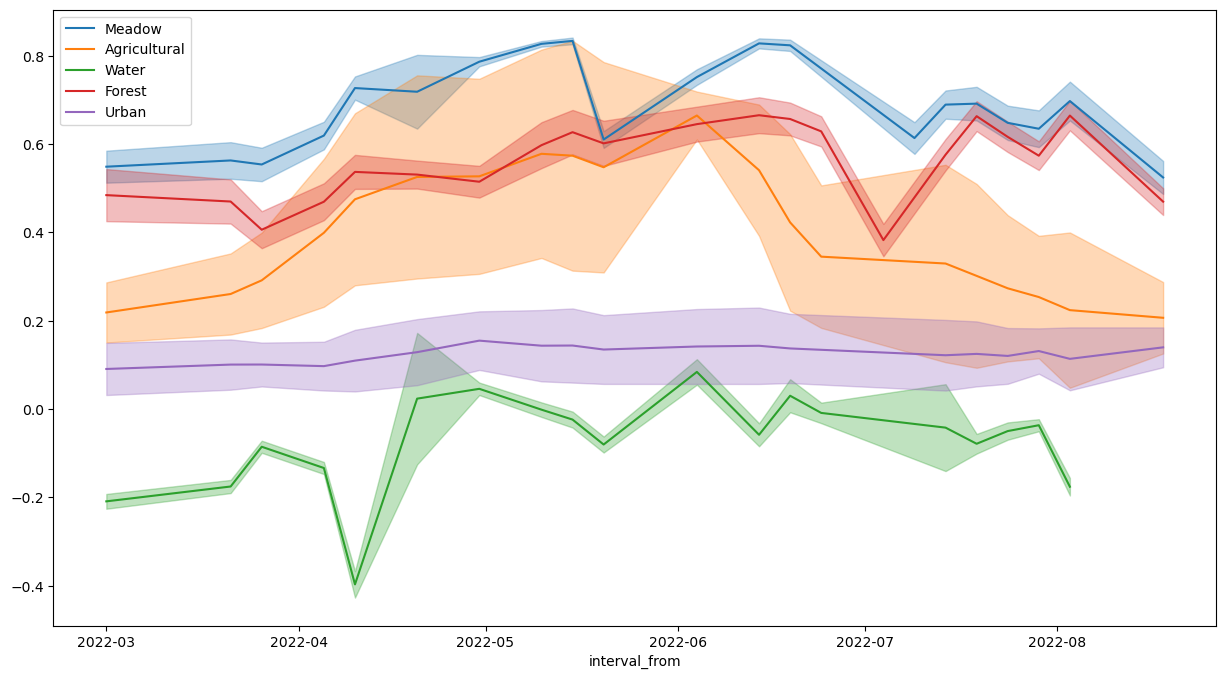

In [60]:
fig, ax = plt.subplots(figsize=(15,8))
#filtered = data[data.indices_CLP_mean<0.2]
filtered = data[data.masks_CLM_mean<0.4]

for idx, _type in enumerate(filtered.type.unique()):
    series = filtered[filtered.type==_type]
    series.plot(ax=ax, x='interval_from', y='indices_NDVI_mean', color=f'C{idx}', label=_type);
    ax.fill_between(series.interval_from.values, series.indices_NDVI_mean-series.indices_NDVI_stDev, series.indices_NDVI_mean+series.indices_NDVI_stDev, color=f'C{idx}', alpha=0.3 );